In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tabulate import tabulate as tab
import types # to use dictionary as an object

# !pip3 install torch torchvision 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# !pip3 install umap-learn
import umap

synthData_path = os.path.join('..', 'synthetic_data') 
sys.path.append(synthData_path)
import generate_synthetic_data as gsd

import gmvae_architecture as ga


## Read Data

In [2]:
# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# data, labels = gsd.read_data_txt(IDs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
data, labels = gsd.read_data_txt(IDs = [1])

case    total    gammas    neutrons    ratio (g/n)    Amax total    Amax gammas    Amax neutrons
------  -------  --------  ----------  -------------  ------------  -------------  ---------------
case1   623142   511540    111602      4.6            1.6763        1.6763         0.7248
---     ---      ---       ---         ---            ---           ---            ---
Total   623142   511540    111602      4.6---         ---           ---


In [3]:
# Merge all cases together
data_merged, labels_merged, neutrons_merged, gammas_merged = gsd.merge_cases_together(data, labels)

# Generate Datasets

In [4]:
bin_edges = np.linspace(0.05, 0.5, 11) # 11 edges → 10 bins

### Training Dataset

In [5]:
X_train, Y_train, time_shifts_pileup_train = gsd.genereate_synthetic_data(
    data = data_merged, 
    labels = labels_merged, 
    bin_edges = bin_edges,
    statistics_n_g_pu = [40000, 40000, 40000], 
    voltage_range = [0.05, 0.5], 
    sigma_noise = 0.001
    )

                    count    percentage of total [%]
------------------  -------  -------------------------
Ntot                623142
count_minThreshold  448931   72.0
count_maxThreshold  0        0.0
count_switch        0        0.0
count_beforePulses  1316     0.2
count_afterPulses   1458     0.2
---                 ---      ---
Nsel                171435   27.5

neutrons clean (tight selection)
 sample shape (10594, 296)
 peak amplitude (min, max) -0.0021 0.7248
 average peak amplitude 0.005327614432442639
 counts per bin: [5617 2617 1065  636  373  142   89   44    7    1]

gammas clean (tight selection)
 sample shape (160841, 296)
 peak amplitude (min, max) -0.0025 1.6763
 average peak amplitude 0.0029209297347035836
 counts per bin: [141539   5239   3536   2291   1547   1256   1005    692    662    590]
NEUTRONS: 40000
Clamped fraction: 0.049475
GAMMAS: 40000
Clamped fraction: 0.05125
PILEUP: 40000

X shape (120000, 296)
sanity check, Y shape (120000,)
time_shifts shape (pile-up

In [6]:
# X_test, Y_test, time_shifts_pileup_test = gsd.genereate_synthetic_data(
#     data = data_merged, 
#     labels = labels_merged, 
#     bin_edges = bin_edges,
#     statistics_n_g_pu = [160000, 160000, 160000], 
#     voltage_range = [0.05, 0.5], 
#     sigma_noise = 0.001
#     )

# Minimal GMVAE: Training

In [7]:
# In our experiments, we sampled 592-ns long waveforms at a fre-
# quency of 500 MSps, therefore, 𝐿 = 296, however, the proposed
# architecture can accommodate pulses of any length. The GMVAE was
# trained over 100 epochs using the Adam optimizer (Kingma and Ba,
# 2015) with a learning rate 10−4 and a batch size 100.

In [8]:
# model parameters
config_dict = {
    "L": X_train.shape[1],    # waveform length (296 in paper)
    "z_dim": 8,              # latent dimension 
    "alpha": 50,             # classification weight in the loss  (50 in paper)
    "batch_size": 128,       # 100 in paper
    "epochs": 50,            # 100 in paper
    "learning_rate": 1e-3,   # 1e-4 in paper
}

config = types.SimpleNamespace(**config_dict)


### DataLoader

In [9]:
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(Y_train, dtype=torch.long)
)
# test_dataset = TensorDataset(
#     torch.tensor(X_test, dtype=torch.float32),
#     torch.tensor(Y_test, dtype=torch.long)
# )

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    drop_last=True
)

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=config.batch_size,
#     shuffle=True
# )

### Initialize model

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ga.GMVAE(L=config.L, z_dim=config.z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate) # weight_decay=1e-5


### Run training

In [11]:
total_loss, total_reco, total_kl, total_ce = [], [], [], []

for epoch in range(config.epochs):
    loss, reco, kl, ce = ga.train_gmv_log(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        device=device,
        alpha=config.alpha
    )
    total_loss.append(loss)
    total_reco.append(reco)
    total_kl.append(kl)
    total_ce.append(ce)

    if epoch % 5 == 0 or epoch == config.epochs - 1:
        print(f"Epoch {epoch:03d} | loss = {loss:.4f}")


Epoch 000 | loss = 4.9265
Epoch 005 | loss = 0.7429
Epoch 010 | loss = 0.6140
Epoch 015 | loss = 0.5770
Epoch 020 | loss = 0.5433
Epoch 025 | loss = 0.5005
Epoch 030 | loss = 0.4878
Epoch 035 | loss = 0.4859
Epoch 040 | loss = 0.4631
Epoch 045 | loss = 0.4660
Epoch 049 | loss = 0.4698


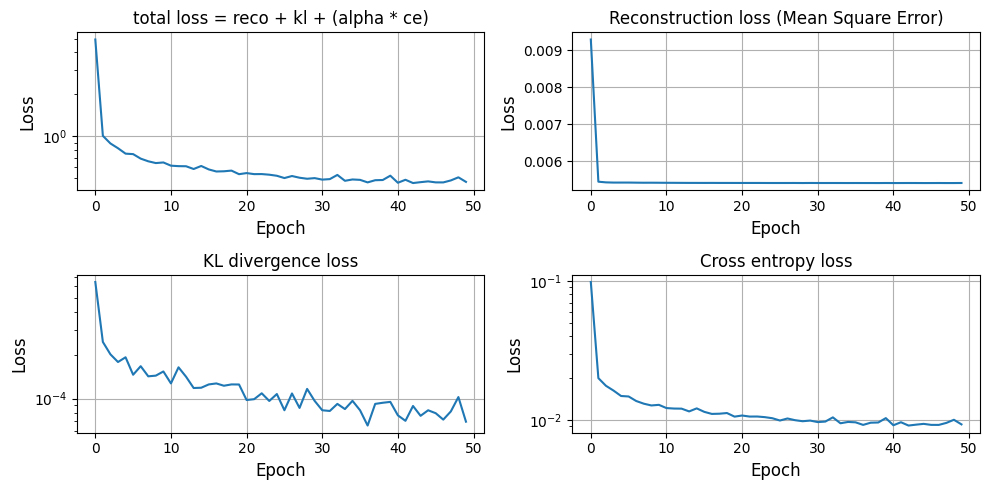

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

axs = axs.flatten()
axs[0].set_title(f'total loss = reco + kl + (alpha * ce)')
axs[1].set_title(f'Reconstruction loss (Mean Square Error)')
axs[2].set_title(f'KL divergence loss')
axs[3].set_title(f'Cross entropy loss')

axs[0].plot(total_loss)
axs[1].plot(total_reco)
axs[2].plot(total_kl)
axs[3].plot(total_ce)


for i in range(0, 4):
    axs[i].set_xlabel("Epoch", fontsize=12)
    axs[i].set_ylabel("Loss", fontsize=12)
    if i!=1:
        axs[i].set_yscale('log')
    axs[i].grid()
plt.tight_layout()
plt.show()

# Checks on training sample (sanity checks and model validation)

In [13]:
# Select N random samples (so that we can have all the classes)
indices = torch.randperm(len(X_train))[:512] # generates a tensor containing a random permutation of the original tensor 
x_test = torch.tensor(X_train[indices]).float().to(device)
y_test = torch.tensor(Y_train[indices]).long().to(device)

# switch to evaluation mode
model.eval()

GMVAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=296, out_features=148, bias=True)
    (fc2): Linear(in_features=148, out_features=74, bias=True)
    (classifier): Linear(in_features=74, out_features=3, bias=True)
    (mu): Linear(in_features=74, out_features=8, bias=True)
    (logvar): Linear(in_features=74, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=8, out_features=74, bias=True)
    (fc2): Linear(in_features=74, out_features=148, bias=True)
    (fc3): Linear(in_features=148, out_features=296, bias=True)
  )
)

## Underfitting test: reconstruction error

 $ \ll 0.1 \rightarrow$ good

 $ \gg 0.5 \rightarrow$ underfitting -> add more layers or increase z_dim (or normalization bug)

In [14]:
model.eval()
with torch.no_grad():
    x_hat, logits, mu, logvar  = model(x_test)
# Calculate overall error (aka reconstruction error)
overall_mse = torch.mean((x_test - x_hat)**2).item()
print(f"Overall MSE: {overall_mse:.6f}")

# Calculate error PER CATEGORY (Critical for VMAE diagnostics)
for label, name in enumerate(['Neutron', 'Gamma', 'Pile-up']):
    mask = (y_test == label)
    if mask.sum() > 0:
        cat_mse = torch.mean((x_test[mask] - x_hat[mask])**2).item()
        print(f"{name} Reconstruction Error: {cat_mse:.6f}")

# Sanity check:
# ≪ 0.1 → good
# ≫ 0.5 → normalization or model bug [underfitting -> add more layers or increase z_dim]

Overall MSE: 0.005793
Neutron Reconstruction Error: 0.000429
Gamma Reconstruction Error: 0.000315
Pile-up Reconstruction Error: 0.016049


## Confusion Matrix

In [15]:
def plot_confusion_matrix(dataloader, model):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            logits, _, _ = model.encoder(x)  # could use the full model instead, but it returns the same values [x_hat, logits, mu, logvar = model(x) -> logits are the same]
            preds = torch.argmax(logits, dim=1)

            y_true.append(y.numpy())
            y_pred.append(preds.cpu().numpy())

    y_true = np.hstack(y_true)
    y_pred = np.hstack(y_pred)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    ConfusionMatrixDisplay(cm, display_labels=['γ','n','p']).plot()
    plt.title("Normalized confusion matrix")
    plt.show()

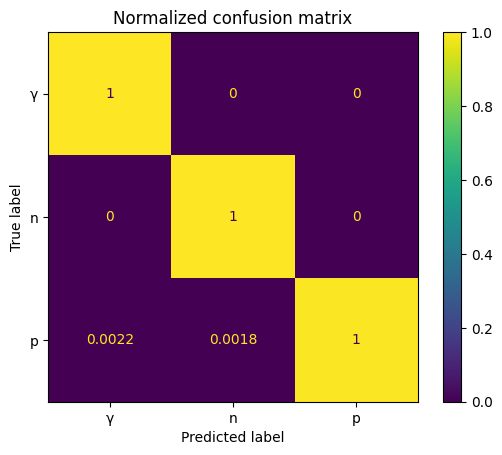

In [16]:
plot_confusion_matrix(train_loader, model)

In [17]:
def log_reconstructions(model, dataloader, device, num_samples=6):
    model.eval()
    class_names = ['γ', 'n', 'p']
    
    with torch.no_grad():
        x_batch, y_true_batch = next(iter(dataloader))
        x_batch = x_batch.to(device)
        
        # Get reconstructions and predictions
        x_hat_batch, logits, _, _ = model(x_batch)
        y_pred_batch = torch.argmax(logits, dim=1).cpu().numpy()
        
        # Convert to numpy
        x_batch = x_batch.cpu().numpy()
        x_hat_batch = x_hat_batch.cpu().numpy()
        y_true_batch = y_true_batch.numpy()

    # Pick samples
    idxs = np.random.choice(len(x_batch), num_samples, replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.flatten()

    for i, idx in enumerate(idxs):
        ax = axes[i]
        ax.plot(x_batch[idx], label='Original', color='#1f77b4', linewidth=1.5)
        ax.plot(x_hat_batch[idx], '--', label='Reconstructed', color='#ff7f0e', linewidth=1.5)
        
        # Formatting
        title_color = 'darkgreen' if y_true_batch[idx] == y_pred_batch[idx] else 'darkred'
        ax.set_title(f"True: {class_names[y_true_batch[idx]]} | Pred: {class_names[y_pred_batch[idx]]}", 
                     fontsize=12, fontweight='bold', color=title_color)
        
        ax.set_xlabel("Time (Samples)")
        ax.set_ylabel("Amplitude")
        ax.grid(True, linestyle=':', alpha=0.6)
        
        if i == 0: # Only add legend to the first plot to save space
            ax.legend(loc='upper right')

    plt.tight_layout()
    
    # Log to WandB
    # wandb.log({"reconstruction_analysis": wandb.Image(plt)})
    # plt.close(fig)



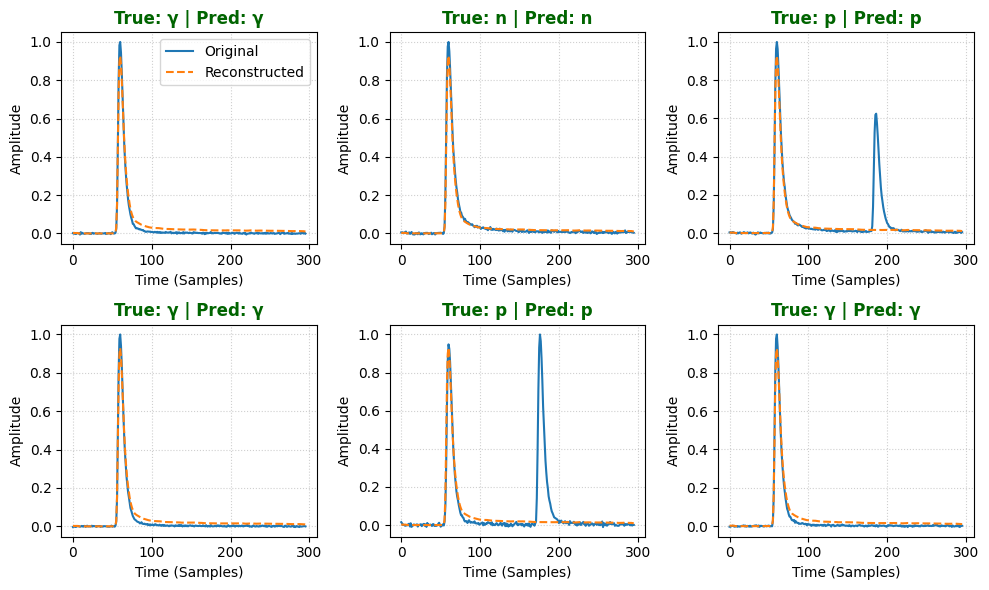

In [18]:
log_reconstructions(model, train_loader, device, num_samples=6)

# pile-up: one peak -> normal (latent space is 8, too small)
# it is not a problem if the pile-up is correctly identified (we don't care about reconstructing it, jsut identifying it)
# TEST: increwase z_dim = (16, 32); reduce alpha